In [1]:
import sys
import numpy as np
import os
import glob
import shutil
import re
import time
import scipy.linalg as sl
import scipy.integrate as si
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
sys.path.append('/home/kranka/github_repos/kranka_ucm/scripts/')
from gauss_hf import *

# dipole moment conversion factor: 1 debye = 0.393430307 a.u.
DtoAU = 0.39343
AUtoD = 1./DtoAU
# energy conversion factor: 1 a.u. = 27.211396 eV
AUtoEV = 27.211396
EVtoAU = 1./AUtoEV
# time: 1 a.u. = 0.02418884254 fs
AUtoFS = 0.02418884
FStoAU = 1./AUtoFS

In [2]:
syst = [1, 2, 3]
homo = np.array([20, 27, 34])
lumo = np.array([21, 28, 35])

In [3]:
traj_txt, traj_dir = [], []
files = glob.glob('./time_occup.*.txt',)
for i in files:
    direc = os.path.abspath(i)
    traj_txt.append(os.path.abspath(direc))
    traj_dir.append(direc.split('time_occup')[0])
traj_txt = sorted(traj_txt)
traj_dir = sorted(list(set(traj_dir)))

print(traj_txt,'\n',traj_dir)

['/home/kranka/proj_isborn/tddft_ml/tdci_comparison/rt/td_mo_occupation/time_occup.sys1_h_field_0.010_cyc_8.txt', '/home/kranka/proj_isborn/tddft_ml/tdci_comparison/rt/td_mo_occupation/time_occup.sys2_h_field_0.005_cyc_8.txt', '/home/kranka/proj_isborn/tddft_ml/tdci_comparison/rt/td_mo_occupation/time_occup.sys3_h_field_0.005_cyc_5.txt'] 
 ['/home/kranka/proj_isborn/tddft_ml/tdci_comparison/rt/td_mo_occupation/']


In [4]:
occ_arr = []
for i in traj_txt:
    occ = np.loadtxt(i)
    occ_arr.append(occ)
for i in occ_arr:
    print(i.shape)

(11846, 35)
(12344, 47)
(11724, 59)


In [9]:
dumstr = traj_txt[2].split('/')[-1].split('.txt')[0].split('_')
amp = dumstr[-3]
cyc = dumstr[-1]
print(f'amp = {amp}; cyc = {cyc}')

amp = 0.005; cyc = 5


In [10]:
traj_labels = [r'$\omega^{\mathrm{LR-TDHF}}_{\mathrm{S}_0 \rightarrow \mathrm{S}_1}$']
ntraj_sys = int(len(traj_txt) / 3)
print(ntraj_sys)

1


In [12]:
mo_list = ['homo','lumo','homo-1','lumo+1']
mo = (mo_list[0], mo_list[1])
MO_occ, avg_occ = [], []
x_all = []
for SY in range(len(syst)):
    occ_tdhf, xshape = [], []
    # '''
    for j in range(ntraj_sys):
        occ_tdhf.append(occ_arr[ntraj_sys*SY+j])
        xshape.append(occ_arr[ntraj_sys*SY+j].shape[0])
        x_all.append(xshape[-1])
#         print(occ_tdhf[-1].shape)
    x_i = min(xshape)
    print(x_i)
    t = occ_tdhf[0][:x_i,0]
    N = 500
    indx_list = [homo[SY],lumo[SY],homo[SY]-1,lumo[SY]+1]
    indx = [indx_list[mo_list.index(i)] for i in mo]
    print(indx, mo)
    if syst[SY] == 3:
        factor = 2
    else:
        factor = 1
    for j in occ_tdhf:
        MO_occ.append(factor*j[:x_i,indx])
#         avg_occ.append(factor*np.convolve(j[:x_i,indx], np.ones(N)/N, mode='full'))
        print(MO_occ[-1].shape)
    # '''
# figtitle = './td_mo_occ_comparison_ress0s1x{}cyc={}_tdhf_s0.png'.format(cyc,amp)
# print(MO_occ[0][:100],)#np.array(avg_occ[0]).shape)

11846
[20, 21] ('homo', 'lumo')
(11846, 2)
12344
[27, 28] ('homo', 'lumo')
(12344, 2)
11724
[34, 35] ('homo', 'lumo')
(11724, 2)


In [13]:
print(min(x_all))

11724


1850
(11724,)
2345
(11724,)
1727
(11724,)
done plotting, processing legend...


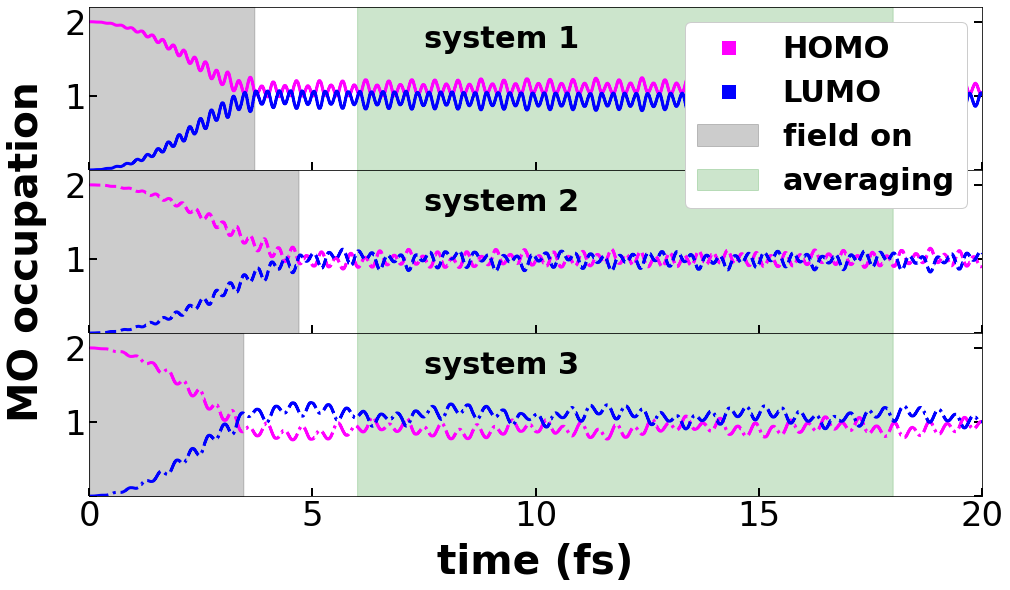

./td_mo_occ_comparison_ress0s1x_tdhf_s0.png


In [30]:
figtitle = './td_mo_occ_comparison_ress0s1x_tdhf_s0.png'

t = np.arange(0,min(x_all),1)
x_lo, x_hi = 0., 20.
dx = 5
y_lo, y_hi = 0., 2.2
dy = 1.
xt = []
for i in range(t.shape[0]):
    xt.append(t[i]*0.002)

colorss = ['magenta', 'blue','black','g','r','c','m','y','tab:brown','tab:purple']
styless = ['-','--','-.',':',]

fig = plt.figure(figsize=(16,9))
l2s = 16/47.25
plt.rcParams.update({
    "axes.labelsize": 45*l2s,
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
    "xtick.labelsize": 100*l2s,
    "ytick.labelsize": 100*l2s,
    "legend.fontsize": 90*l2s,
})
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
xlabel = 'time (fs)'
ylabel = 'MO occupation'#\n(moving average, window = {} steps)'
# fig.suptitle(r'$\omega_{\mathrm{pert}} = \omega^{\mathrm{CASSCF}}_{\mathrm{S}_0 \rightarrow \mathrm{S}_2} / 2$ (max. LUMO occupation)', y=0.93, fontsize=90*l2s,)
plt.xlabel(xlabel, fontdict={'size': 120*l2s,'weight': 'bold',}, labelpad=30*l2s)
axs[1].set_ylabel(ylabel, fontdict={'size': 120*l2s,'weight': 'bold',}, labelpad=50*l2s)
#
x_tick_lo, x_tick_hi = (x_lo), (x_hi + dx)
y_tick_lo, y_tick_hi = (y_lo), y_hi
plt.xlim(x_lo,x_hi); plt.xticks([round(i,1) for i in np.arange(x_tick_lo, x_tick_hi, step=dx)])
plt.ylim(y_lo,y_hi); plt.yticks(np.arange(y_tick_lo, y_tick_hi, step=dy))
traj_colors = []
for i in range(ntraj_sys):
    traj_colors.append(colorss[i])
sys_styles = []
for i in range(len(syst)):
    sys_styles.append(styless[i])
# Hide x labels and tick labels for all but bottom plot.
# if mo == 'homo':
#     if '_s0' in figtitle:
#         pos = [(1.5,0.45),(5.5,0.45),(1.25,0.35),]                    # HOMO S0
#     elif '_s1' in figtitle:
#         pos = [(1.5,0.45),(1.5,0.45),(1.5,0.35),]                     # HOMO S1
# elif mo == 'lumo':
#     if '_s0' in figtitle:
#         pos = [(2.5,0.75*y_hi),(2.5,0.85*y_hi),(2.5,0.86*y_hi),]            # LUMO S0
#     elif '_s1' in figtitle:
#         pos = [(1.25,0.85*y_hi),(1.25,0.85*y_hi),(1.25,0.85*y_hi),]   # LUMO S1
pos = [(2.5,0.75*y_hi),(2.5,0.75*y_hi),(2.5,0.75*y_hi),]            # LUMO S0
toff = [1850,2345,1727,]
SY = 0
for ax in axs:
    ax.label_outer()
    ax.tick_params(direction='in',right=True,width=2,length=8)
    if ax != 2:
        ax.set_yticks([0,1,2],labels=['',1,2])
    for traj in range(ntraj_sys):
        ax.plot(xt,MO_occ[ntraj_sys*SY+traj][:len(xt),0], color=colorss[traj],linestyle=sys_styles[SY], lw=3,)
        ax.plot(xt,MO_occ[ntraj_sys*SY+traj][:len(xt),1], color=colorss[traj+1],linestyle=sys_styles[SY], lw=3,)
    print(toff[SY])
    print(t.shape)
    ttrunc = xt[:toff[SY]]
    ax.fill_between(x=ttrunc,y1=2.2*np.ones_like(ttrunc),color="k",alpha=0.2,)
    twin = xt[3000:9000]
    ax.fill_between(x=twin,y1=2.2*np.ones_like(twin),color="g",alpha=0.2,)
    ax.text(pos[SY][0]+5, pos[SY][1], r'system {}'.format(SY+1), fontsize = 90*l2s, color='k',weight='bold')
    SY += 1
print('done plotting, processing legend...')
handles, labels = ax.get_legend_handles_labels()
# Patch(facecolor='r', edgecolor='r', label=r'$\omega_{\mathrm{pert}}$', alpha=0.5),
l3 =[]
# for i in range(len(syst)): l3.append(Line2D([0], [0], color='k', linestyle=sys_styles[i], lw=3, label=r'system {}'.format(i+1),))
# for i in range(ntraj_sys): l3.append(Line2D([0], [0], color=traj_colors[i], linestyle=sys_styles[i], lw=3, label=traj_labels[i],))
for i in range(ntraj_sys):
#     l3.append(Line2D([0], [0], color='k', linestyle=sys_styles[i], lw=3, label=traj_labels[i],))
    l3.append(Line2D([0], [0], marker='s', color='w', markerfacecolor=colorss[i], markersize=15, label='HOMO',),)
    l3.append(Line2D([0], [0], marker='s', color='w', markerfacecolor=colorss[i+1], markersize=15, label='LUMO',),)
    l3.append(Patch(facecolor='k', edgecolor='black', label=r'field on', alpha=0.2,),)
    l3.append(Patch(facecolor='g', edgecolor='green', label=r'averaging', alpha=0.2,),)
fig.legend(handles=l3, loc='upper right',bbox_to_anchor=(0.9, 0.88),framealpha=1.0,prop={'weight':'bold',},)#title=traj_labels[0],).get_title().set_fontsize('{}'.format(80*l2s))
plt.show()
print(figtitle)
fig.savefig(figtitle)